# Interpretable home price predictions
### Lee Mackey & John Naujoks

In [335]:
# General setup imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Regression analysis tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from stepwise_selection import stepwise_selection
from sklearn.model_selection import cross_val_score

### Data Understanding

In [287]:
kc_housing = pd.read_csv('kc_house_data.csv')
kc_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [288]:
# Looking at columns type and if complete, and viewing which columns have null values that need to be addressed.
kc_housing.isna().sum(), kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


(id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront       2376
 view               63
 condition           0
 grade               0
 sqft_above          0
 sqft_basement       0
 yr_built            0
 yr_renovated     3842
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 dtype: int64, None)

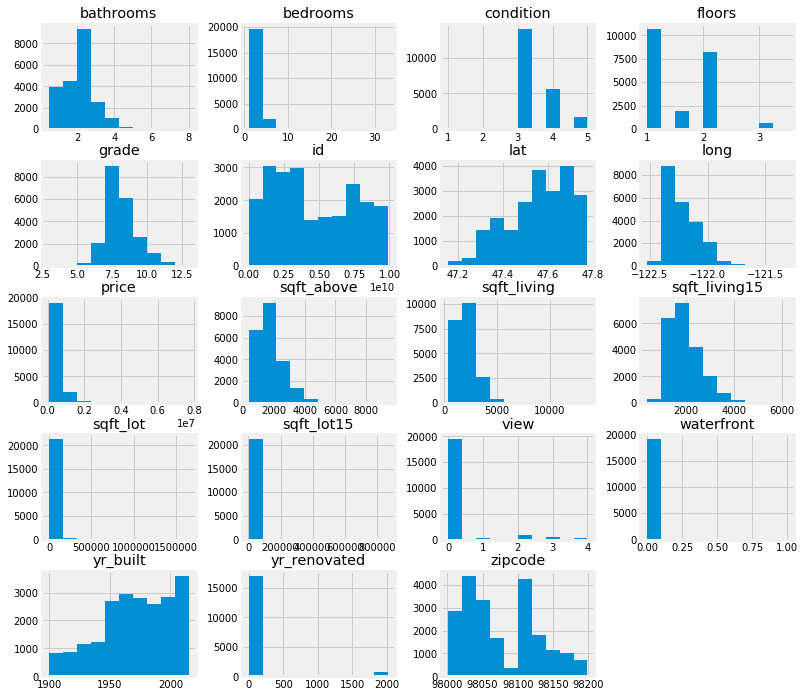

In [175]:
# A general view of the shape of our columns data
_ = kc_housing.hist(figsize=(12,12))

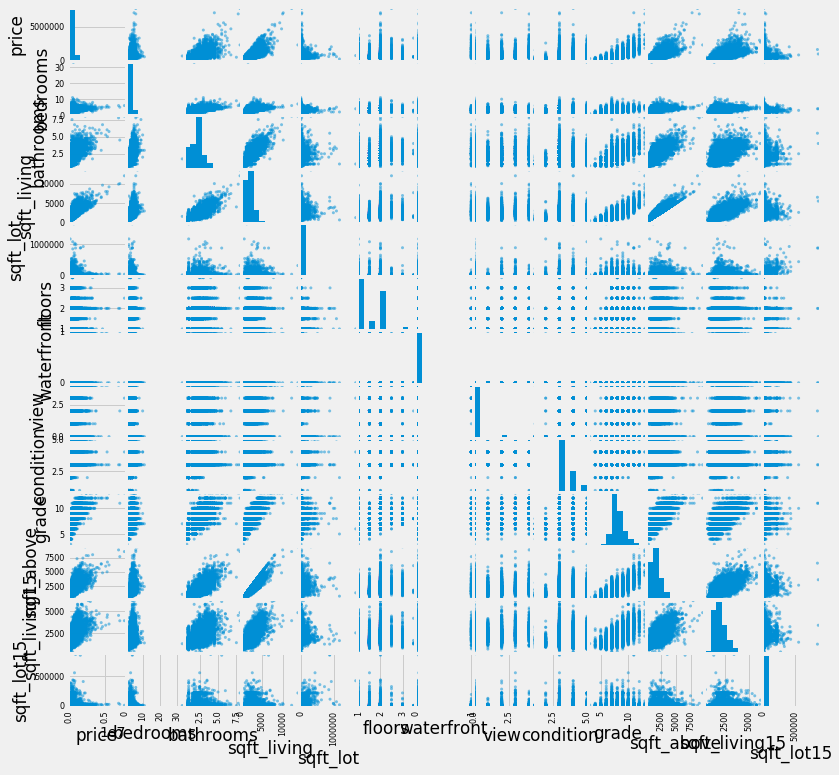

In [236]:
# A very large (and slow) scatter matrix to look at all the potential relationships.
potential_cols = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors',
                     'waterfront', 'view','condition','grade','sqft_above','sqft_basement',
                     'sqft_living15','sqft_lot15']

_ = pd.plotting.scatter_matrix(kc_housing[potential_cols], figsize=(12,12))

#### Notes on results:
   - rectangular data structured as expected upon import
   - noted apparent presence of NaNs in 3 columns
   - apparent presence of non-normal distribution in target “price” column and some features

### Data Preparation

Dropping for now:
* Id: Does not feel necessary for our exploration and will drop this column
* Date: Going to use for some computations, but not do not need the variable on its own.
* Sqft_above: With ample other features for our property size, we decided to pass on using the characteristic for the time being as it is so highly correlated to other features that feel can significantly contribute to our model, like sqft_living.
* Latitude & Longitude: for location purses, we are going to do some exploring with the ZIP code.

In [289]:
kc_measures = kc_housing.drop(['id','date','sqft_above','lat','long'], axis=1).copy()

Cleaning NaN values:
* Waterfront: data is both incomplete and appears to be very primarily negative. Since the value is already binary, we are marking all the NaN values negative as to match to majority. Since it is so skewed, we will re-evaluate its utitlity later.
* Yr_renovated: To handle missing values, we collapsed this variable into binary for denoting renovation (True), or no value or no listed renovation year (False). Similar to waterfront, the majority did not have this value.
* View: The view variable has a couple issues. First, there are some null values in this column.  Since there are only 63 and we have a significant amount of other rows to work with, we dropped these rows.  Second, the value for 'view' seems like a small difference between those with and without views, so it felt more useful to collapse the granuality of number of views to a simple binary for "viewed" (True), "not viewed"(False)

In [290]:
kc_measures['waterfront'] = kc_measures['waterfront'].fillna(0.0)

kc_measures['renovated'] = np.where(kc_measures['yr_renovated']>0, 1, 0) 
kc_measures.drop('yr_renovated', axis=1, inplace=True)

kc_measures['view'] = kc_measures['view'].dropna(axis=0)
kc_measures['view'] = np.where(kc_measures['view']> 0, 1, 0)

Other data errors:
* Sqft_basement: In exploring this column, we found that some were marked with a question mark instead of a value. It appears that this column was a computation from sqft_living. Our decision was to test this variable as a binary value equating to having a basement(True), or no basement listed (False)

In [291]:
kc_measures['sqft_basement'] = kc_measures['sqft_basement'].str.replace('?', '0.0').astype('float')

In [292]:
kc_measures['basement'] = np.where(kc_measures['sqft_basement'] > 0, 1, 0)
kc_measures.drop('sqft_basement', axis=1, inplace=True)

Working with Zip Codes:
* We created dummy variables for each individual ZIP code.

In [293]:
df_zipcode_dums = pd.get_dummies(kc_measures['zipcode'])
kc_measures_wzip = pd.concat([kc_measures, df_zipcode_dums], axis=1)

Creating a Feature from Year Built:
* Creating scalar values for the year value for "newness" of yr_built (absolute value of difference from 1899)

In [294]:
kc_measures['yr_built_1899refyr'] = kc_measures['yr_built'].apply(lambda x: abs(1899-x))
kc_measures.drop('yr_built', axis=1, inplace=True)

Further notes:
* Bedrooms: The data appears complete, though has some heavy outliers on the higher end (one with 33 bedrooms!) which may need to be min-max standardized
* Bathrooms: Comporable to bedrooms, may need to be adjusted for outliers, but complete.
* Yr_built: To make this column more useful, we are going to convert it into its age in years (subtract current year)
* Yr_renovated: data is fairly incomplete, so might want to skip
* Sqft Living 15: Based on the graphs, it looks like we might find some helpful relationship

Here are the key features we ran our modelling tests on:

In [295]:
len(kc_measures.columns)

16

In [296]:
kc_measures.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'renovated', 'basement', 'yr_built_1899refyr'],
      dtype='object')

### Modeling

Our initial simple linear regression test:
* We put price on standard scale just to see the effect and get an RMSE that might be more proportionally readble. 

In [297]:
# Setting variables
X = kc_measures[['sqft_living']]
y = np.log(kc_measures[['price']])

In [298]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = linreg.predict(X_test)

In [299]:
 # See the R Squared score for on our test data
r2 = r2_score(y_test, y_hat_test)

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)

print(f"RMSE: {test_rmse}\nR2: {r2}")

RMSE: 0.376021572921254
R2: 0.4917103753475145


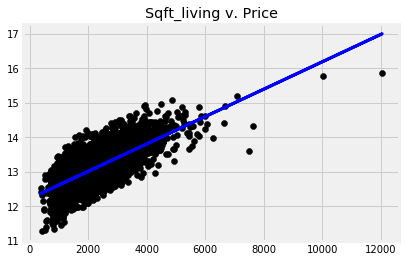

In [300]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(X_test, y_test,  color='black')
ax.plot(X_test, y_hat_test, color='blue', linewidth=3)
ax.set_title('Sqft_living v. Price')
plt.show()

#### Log transformation on Price:
For the purposes of our model building, we decided it would be best to use the logged value of our prices for a couple of reasons: 
1. This form helps normalize our prices, as it is currently very positively skewed (as displayed below).
2. The metric we will receive from our modeling function becomes much more readable and coparable in running our analysis as well. In using the model for future interpretation, we would not keep this feature manipulated in this way. 

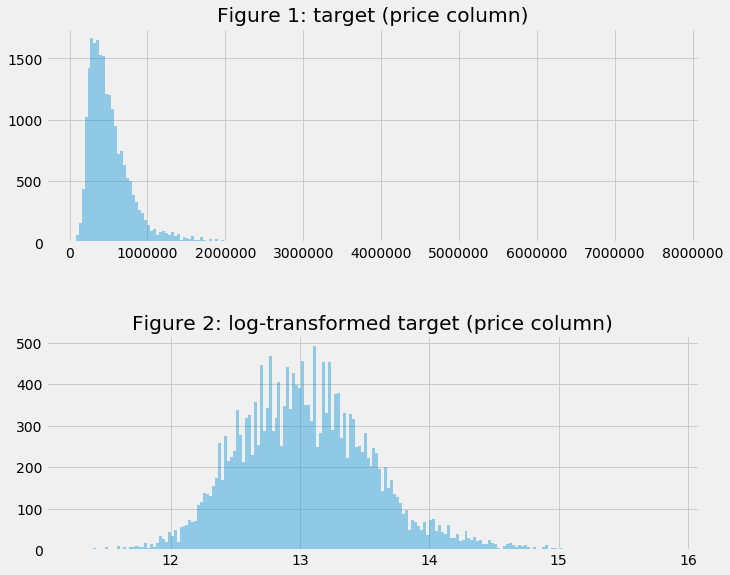

In [301]:
plt.style.use('fivethirtyeight')

X = kc_measures.price
X_log = np.log(kc_measures.price)
X = kc_measures.price

fig, ax = plt.subplots(2, 1, figsize=(10,8))
fig.tight_layout(h_pad=5)
grid = plt.GridSpec(2, 1, hspace=10)

ax[0].hist(X, bins=200, alpha=0.4)
ax[1].hist(X_log, bins=200, alpha=0.4)
ax[0].set_title('Figure 1: target (price column)')
ax[1].set_title('Figure 2: log-transformed target (price column)')
plt.show()

#### Notes on results:
* On its own, sqft_living does appear to be on the right track of variables to help predict price, based on its scoring and a brief assessment of the visualization.
* Based on reviewing our data, we came up with an initial breakdown of looking at the features:
    * Structure - bedrooms, bathrooms, floors, condition, grade, renovated, basement, sqft_living, basement
    * Lot - sqft_lot, sqft_lot15, sqft_living15, waterfront, view
    * Location - zipcode

####  Creating some multivariate regression models

We made a quick function to help do the following for us:
1. Seperate out the Y ('price') and converting to log values (just for ease of reading) 
2. Setting our X (all other dataframe variables)
2. Create a train-test split on that data.
3. Run the training data through the linear regression function. 
4. Return a set of useful statistics to review their performance (R-Squared, MSE, RMSE, MAE)

In [302]:
def lin_regress_summary(df):

    y = np.log(df['price'])
    X = df.drop(['price'], axis=1)

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test

    # See the R Squared score
    r2 = r2_score(y_test, y_hat_test)
    print(f"the R^2 score is: {r2}")

    # See our Mean Squared Error
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    # See our Root Mean Squared Error
    test_rmse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_rmse}")
    
    # See our Mean Absolute Error
    test_mae = mean_absolute_error(y_test, y_hat_test)
    print(f"the test MAE is: {test_mae}")
    
    # Optional OLS test used to look into larger results, and check p-values
    # model = sm.OLS(y, X)
    # results = model.fit()
    # print(results.pvalues[results.pvalues > .05])

#### Testing all variables against price:

In [303]:
lin_regress_summary(kc_measures)

the R^2 score is: 0.6504564360091668
the test MSE is: 0.09551747275257581
the test RMSE is: 0.3090590117640575
the test MAE is: 0.24628271712007097


#### Testing all variables WITH all ZIP codes as dummy variables

In [304]:
lin_regress_summary(kc_measures_wzip)

the R^2 score is: 0.8670807840046499
the test MSE is: 0.03699578498947064
the test RMSE is: 0.1923428839065034
the test MAE is: 0.13943249810570518


Based just on this initial assessment, it appeared that the ZIP codes were a great help to improving our model, both in its representativeness to the data (R^2) and its potential for model prediction (RMSE & MAE).

With that knowledge, we began running several iterations of our variables without the ZIP codes to find the strongest ones, and then adding them along with our ZIP code variables.

First, a couple models based on that simple seperation of characteristics:

In [305]:
kc_m_lot = kc_measures[['price','sqft_lot', 'waterfront', 'view',
                        'sqft_living15','sqft_lot15', ]]

In [306]:
lin_regress_summary(kc_m_lot)

the R^2 score is: 0.4125757742703926
the test MSE is: 0.16234075371982062
the test RMSE is: 0.4029153182987967
the test MAE is: 0.3189124389611762


In [307]:
kc_m_structure = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                              'floors', 'condition', 'grade', 'renovated', 'basement']]

In [308]:
lin_regress_summary(kc_m_structure)

the R^2 score is: 0.5761825802638088
the test MSE is: 0.11386925635221684
the test RMSE is: 0.3374451901453284
the test MAE is: 0.2696373137617122


Next, we took a quick look at the results of a stepwise selector (function originally found on Learn.co, modified to take in a dataframe, know the 'price' is our key variable, and test the rest):

In [309]:
stepwise_selection(kc_measures)

['waterfront',
 'grade',
 'sqft_living',
 'yr_built_1899refyr',
 'view',
 'bedrooms',
 'bathrooms',
 'sqft_lot15',
 'condition',
 'floors',
 'sqft_living15',
 'renovated',
 'basement']

Attempted as well with the ZIP codes variables, but in subsetting were marginally as useful as the complete set.

In [310]:
# = pd.concat([kc_measures[['price']], df_zipcode_dums], axis=1)
# stepwise_selection(kc_zips_wprice)

In [311]:
kc_m_step_results = kc_measures[['price','bedrooms', 'bathrooms','sqft_living',
                                 'floors','waterfront', 'view', 'condition','grade',
                                 'sqft_living15', 'sqft_lot15', 'renovated', 'basement',
                                 'yr_built_1899refyr']]

In [312]:
lin_regress_summary(kc_m_step_results)

the R^2 score is: 0.6471640634571953
the test MSE is: 0.09497395222047472
the test RMSE is: 0.3081784421734829
the test MAE is: 0.24538729707240614


Based on these results, ran several more tests and tried a number of different configurations:

In [313]:
kc_m_var_1 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade',
                            'zipcode', 'sqft_living15','sqft_lot15', 'renovated',
                            'basement', 'yr_built_1899refyr']]

In [314]:
lin_regress_summary(kc_m_var_1)

the R^2 score is: 0.6316266412773498
the test MSE is: 0.09578820269405244
the test RMSE is: 0.3094966925413783
the test MAE is: 0.24597505581808893


In [315]:
kc_m_var_2 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade',
                            'sqft_living15','sqft_lot15',  'basement', 'yr_built_1899refyr']]

In [316]:
lin_regress_summary(kc_m_var_2)

the R^2 score is: 0.6374255534649493
the test MSE is: 0.09841057068917751
the test RMSE is: 0.31370459143783264
the test MAE is: 0.2504014321613929


In [317]:
kc_m_var_3 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot','view', 'condition', 'grade', 'sqft_living15',
                               'sqft_lot15','yr_built_1899refyr']]

In [318]:
lin_regress_summary(kc_m_var_3)

the R^2 score is: 0.6381360887993653
the test MSE is: 0.10009615680999981
the test RMSE is: 0.3163797667519208
the test MAE is: 0.2516239117296407


In [319]:
kc_m_var_4 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view',  'grade', 'sqft_living15',
                               'sqft_lot15', 'yr_built_1899refyr']]

In [320]:
lin_regress_summary(kc_m_var_4)

the R^2 score is: 0.6296559208559427
the test MSE is: 0.09986594624481542
the test RMSE is: 0.31601573733726523
the test MAE is: 0.2523634908324127


In [321]:
kc_m_var_5 = kc_measures[['price', 'bedrooms', 'sqft_living','waterfront',
                          'view', 'grade', 'yr_built_1899refyr']]

In [322]:
lin_regress_summary(kc_m_var_5)

the R^2 score is: 0.6258274905037349
the test MSE is: 0.10440965878063756
the test RMSE is: 0.3231248346701899
the test MAE is: 0.25888674639663395


With keeping in mind some of what we saw from our model tests, we ran further tests including our ZIP code dummy variables combined with our other variable measures:

In [323]:
kc_use_6 = kc_measures[['price','waterfront', 'view', 'bedrooms',
                      'sqft_living', 'grade', 'yr_built_1899refyr']]
kc_m_var_6 = pd.concat([kc_use_6, df_zipcode_dums], axis=1)

In [324]:
lin_regress_summary(kc_m_var_6)

the R^2 score is: 0.8560631879984499
the test MSE is: 0.03894009513716482
the test RMSE is: 0.19733244826222782
the test MAE is: 0.14421011171281012


In [325]:
kc_use_7 = kc_measures[['price','sqft_living','bedrooms','bathrooms', 'grade', 'sqft_lot']]
kc_m_var_7 = pd.concat([kc_use_7, df_zipcode_dums], axis=1)

In [326]:
lin_regress_summary(kc_m_var_7)

the R^2 score is: 0.8520896975380441
the test MSE is: 0.042730825280064215
the test RMSE is: 0.20671435673427285
the test MAE is: 0.1487761402066921


#### Notes of results:

Based on all our variations, it appears that our model for "kc_m_var_6" has the best potential.  From here, we will further check and test our model.



### Evaluation

##### Does my selection of features have any excessive multicollinearity?
To check our other selected variables, we are looked for multicollinearity through the table below and explored the heatmap:

In [327]:
kc_use_6.corr()

,price,waterfront,view,bedrooms,sqft_living,grade,yr_built_1899refyr
price,1.000000,0.264306,0.356243,0.308787,0.701917,0.667951,0.053953
waterfront,0.264306,1.000000,0.248683,-0.002127,0.104637,0.082818,-0.024487
view,0.356243,0.248683,1.000000,0.079232,0.268465,0.235252,-0.063826
bedrooms,0.308787,-0.002127,0.079232,1.000000,0.578212,0.356563,0.155670
sqft_living,0.701917,0.104637,0.268465,0.578212,1.000000,0.762779,0.318152
grade,0.667951,0.082818,0.235252,0.356563,0.762779,1.000000,0.447865
yr_built_1899refyr,0.053953,-0.024487,-0.063826,0.155670,0.318152,0.447865,1.000000


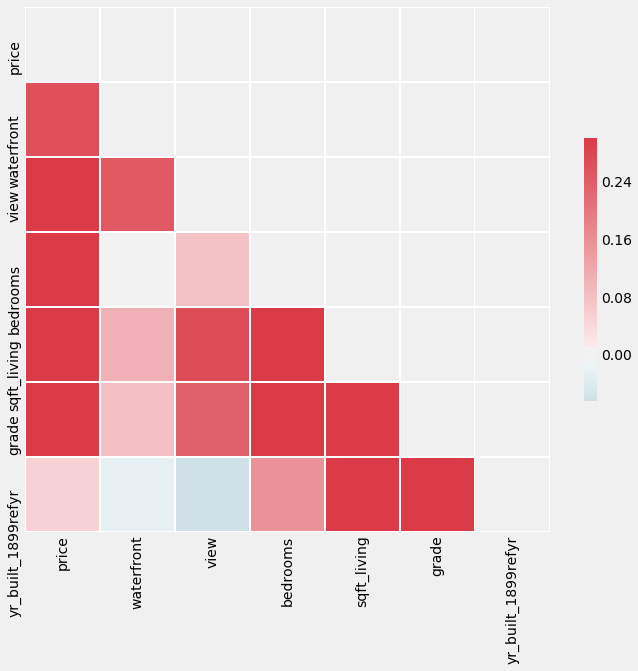

In [328]:
#Heatmap view of how the variables relate:
corr = kc_use_6.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

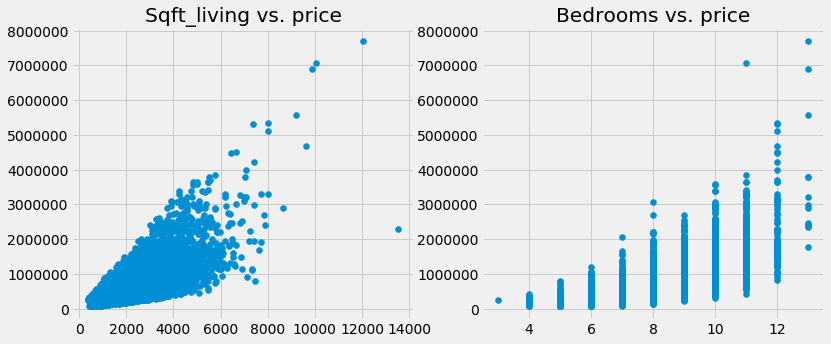

In [329]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(kc_use_6['sqft_living'], kc_use_6['price'])
ax[0].set_title("Sqft_living vs. price")

ax[1].scatter(kc_use_6['grade'], kc_use_6['price'])
ax[1].set_title("Bedrooms vs. price")

plt.show()

Based on this information, it appears that 'grade' is highly correlated with 'sqft_living', which does intrinsically make sense. To conteract that, we decided to drop that feature from our model.

In [330]:
kc_model = kc_measures[['price','waterfront','view','bedrooms','sqft_living', 'yr_built_1899refyr']].copy()

kc_model_complete = pd.concat([kc_model,df_zipcode_dums], axis=1)

##### Are my ZIP code values all acceptable?
In further evaluating the Zip Codes, we found three with p-values greater than .05 and dropped them from our model.

In [331]:
kc_model_complete.drop([98011, 98024, 98077], axis=1, inplace=True)

In [332]:
lin_regress_summary(kc_model_complete)

the R^2 score is: 0.8366632845499338
the test MSE is: 0.04420424575724677
the test RMSE is: 0.2102480576777031
the test MAE is: 0.15442159048324683


#### Testing K-Folds Cross Validation

In [333]:
y = np.log(kc_model_complete['price'])
X = kc_model_complete.drop(['price'], axis=1)

In [334]:
# Perform K-Folds
cv_results_5_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X, y,
                                                        cv=5, scoring='neg_mean_absolute_error'))))
cv_results_5_MAE = np.mean(abs(cross_val_score(linreg, X, y,
                                                cv=5, scoring="neg_mean_absolute_error")))
cv_results_10_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X, y,
                                                         cv=10, scoring="neg_mean_squared_error"))))
cv_results_10_MAE = np.mean(abs(cross_val_score(linreg, X, y,
                                                cv=10, scoring="neg_mean_absolute_error")))
cv_results_20_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X, y,
                                                         cv=20, scoring="neg_mean_squared_error"))))
cv_results_20_MAE = np.mean(abs(cross_val_score(linreg, X, y,
                                                cv=20, scoring="neg_mean_absolute_error")))

print(f"K-Fold Cross Val 5 RMSE: {cv_results_5_RMSE}, MAE: {cv_results_5_MAE} ")
print(f"K-Fold cross val 10 RMSE: {cv_results_10_RMSE}, MAE: {cv_results_10_MAE}")
print(f"K-Fold cross val 20 RMSE: {cv_results_20_RMSE}, MAE: {cv_results_20_MAE}")

K-Fold Cross Val 5 RMSE: 0.39309665395788773, MAE: 0.15454675391120185 
K-Fold cross val 10 RMSE: 0.20999848624033382, MAE: 0.1544339531542415
K-Fold cross val 20 RMSE: 0.20969616992597123, MAE: 0.1543142954670379


#### Notes on results:
* Our evaluation steps provided some additional considerations and altered some of our models features. Overall, through further validation, our model still appears to be our strongest option to help predict home price in the future.

### Deployment

In [268]:
# Deployment of model!

##### Graveyard of Features

The following are a seleciton of features we drafted, modeled with other variables, and found not a significant enough impact to include in our model.

#### Yard Size: all square footage outside of the living area (Sqft_Living - Sqft_Lot)

In [0]:
# kc_measures['yard'] = kc_measures['sqft_living'] - kc_measures['sqft_lot']

#### Seasons: taking the month sold during the year and grouping into four seasons. Tried just months as well, but sales were fairly even by month.

In [0]:
# kc_mod['month'] = kc_mod['date'].apply(lambda x: x[:2]).str.replace('/','').astype(int)

# def quarter(val):
#     if val in range(3):
#         return '1-3'
#     elif val in range(4,7):
#         return '4-6'
#     elif val in range(7,10):
#         return '7-9'
#     elif val in range(10,13):
#         return '10-12'
    
# kc_mod['month'] = kc_mod['month'].apply(lambda x: quarter(x))
# kc_mod['month'].value_counts()
# df_month_dums = pd.get_dummies(kc_mod['month'])
# kc_mod = pd.concat([kc_mod, df_month_dums], axis=1)

#### Distance from Expensive neighborhoods: Based on article found from 2017 with most expensive neighborhoods, create values for distance from those expensive neighborhood centers.  This method we did not finish testing, but feel that some of its subtley may be picked up in ZIP codes 

<a href="https://seattle.curbed.com/2017/10/11/16462132/seattle-cheap-expensive-neighborhoods-buying-home">Original article<a>

In [0]:
# Test for location close to expensive areas
# kc_loc = kc_housing.drop(['id','date','sqft_above'], axis=1).copy()
# kc_loc['loc'] = (kc_loc['lat'] + 90) * (180 + kc_loc['long'])
# kc_loc.drop(['lat','long'], axis=1, inplace=True)
#location = (lat + 90) * 180 + long

# downtown = (47.60806 + 90) * (180 + -122.33611)

# madrona = (47.613274 + 90) * (180 + -122.28887)
# slu = (47.62343 + 90) * (180 + -122.33435)
# eastlake = (47.64708 + 90) * ( 180 + -122.32477)
# queen_anne = (47.63692 + 90) * (180 + -122.35579)
# magnolia = (47.65056 + 90) * (180 + -122.40083)
# first_hill = (47.60864 + 90) *(180 + -122.32679)

# #location = (lat + 90) * 180 + long

# kc_expensive = kc_housing.drop(['id','date','sqft_above'], axis=1).copy()
# kc_expensive['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_loc['loc_downtown'] = kc_loc['loc'].apply(lambda x: abs(x - downtown))

# kc_expensive['loc_madrona'] = kc_expensive['loc'].apply(lambda x: x - madrona)
# kc_expensive['loc_slu'] = kc_expensive['loc'].apply(lambda x: x - slu)
# kc_expensive['loc_eastlake'] = kc_expensive['loc'].apply(lambda x: x - eastlake)
# kc_expensive['loc_queen_anne'] = kc_expensive['loc'].apply(lambda x: x - queen_anne)
# kc_expensive['loc_magnolia'] = kc_expensive['loc'].apply(lambda x: x - magnolia)
# kc_expensive['loc_first_hill'] = kc_expensive['loc'].apply(lambda x: x - first_hill)

#### In Seattle: Trying a simple binary "In Seattle"-> True, "Not Seattle"-> False. A slimmer option, but might not provide the subltey of neighborhood variation. In running tests of both this metric and ZIP codes as dummy variables, we found Zip code dummies to more positively effect the metrics we were monitoring (R-Squared & RMSE), so we went with the dummy variables.  Below shows the process used for the "In Seattle" variation.

In [168]:
# seattle_zips = [98101, 98102, 98104, 98105, 98108, 98109, 98112, 98113, 98114, 98117, 98103, 98106, 98107,
#                 98111, 98115, 98116, 98118, 98119,98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 
#                 98122, 98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148, 98155, 98160, 98161, 
#                 98164, 98165, 98168, 98170, 98146, 98154, 98158, 98166, 98174, 98175, 98178, 98190, 98191,
#                 98177, 98181, 98185, 98188, 98189, 98194, 98195, 98199,98198]

# kc_measures['in_seattle'] = kc_measures['zipcode'].map(lambda x: 1 if x in seattle_zips else 0)
# kc_measures.drop('zipcode', axis=1, inplace=True)